<a href="https://colab.research.google.com/github/Arta-DS/DS/blob/main/%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8_%D0%B4%D0%B5%D1%82%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [184]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from skimage.feature import hog
from sklearn.model_selection import RandomizedSearchCV

## Загружаем исходные данные

In [ ]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_images = train[:, 1:].reshape(-1, 28, 28).astype(np.float32)
test_images = test.reshape(-1, 28, 28).astype(np.float32)

train_images.shape

## Визуализируем исходные данные

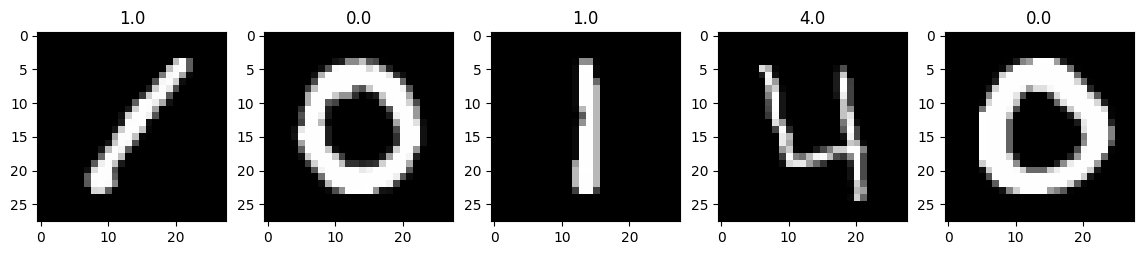

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_images[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

# Модель 1

In [ ]:
# Улучшенная предобработка изображений
def preprocess_images(images):
    processed = []
    for img in images:
        # Улучшение контраста с помощью эквализации гистограммы
        img = cv2.equalizeHist(img.astype(np.uint8))
        # Нормализация значений пикселей
        img = img.astype(np.float32) / 255.0
        processed.append(img)
    return np.array(processed)

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [ ]:
# Улучшенное извлечение признаков HOG + статистические признаки
def extract_features(images):
    features = []
    for img in images:
        # Вычисление градиентов с помощью оператора Собеля
        gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)

        # Преобразование градиентов в полярные координаты
        magnitude, angle = cv2.cartToPolar(gx, gy)

        # Гистограмма ориентаций градиентов (HOG)
        hist, _ = np.histogram(angle, bins=9, range=(0, np.pi),
                              weights=magnitude, density=True)

        # Добавление статистических характеристик
        features.append([
            *hist,
            np.mean(magnitude), np.std(magnitude),
            np.mean(gx), np.std(gx),
            np.mean(gy), np.std(gy)
        ])
    return np.array(features)

X = extract_features(train_images)
X_test = extract_features(test_images)

In [ ]:
# Применение PCA для уменьшения размерности
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X)
X_test_pca = pca.transform(X_test)

In [ ]:
# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)
X_test_scaled = scaler.transform(X_test_pca)

In [ ]:
# Разделение данных на обучение и валидацию
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, train_label, test_size=0.2, random_state=42)

In [ ]:
# Обучение SVM-классификатора с оптимизированными параметрами
clf = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
clf.fit(X_train, y_train)

SVC(C=10, random_state=42)

In [ ]:
# Оценка качества модели на валидационной выборке
val_predictions = clf.predict(X_val)
print(f'Точность на валидации: {accuracy_score(y_val, val_predictions):.4f}')
print(classification_report(y_val, val_predictions))

Точность на валидации: 0.5933
              precision    recall  f1-score   support

         0.0       0.58      0.65      0.61       816
         1.0       0.97      0.97      0.97       909
         2.0       0.37      0.25      0.30       846
         3.0       0.56      0.68      0.61       937
         4.0       0.66      0.63      0.64       839
         5.0       0.54      0.60      0.57       702
         6.0       0.40      0.35      0.37       785
         7.0       0.80      0.70      0.75       893
         8.0       0.42      0.48      0.44       835
         9.0       0.55      0.56      0.56       838

    accuracy                           0.59      8400
   macro avg       0.58      0.59      0.58      8400
weighted avg       0.59      0.59      0.59      8400



In [ ]:
# Предсказание на тестовых данных и формирование файла для отправки
test_predictions = clf.predict(X_test_scaled)
with open('submission.csv', 'w') as f:
    f.write('ImageId,Label\n')
    for i, label in enumerate(test_predictions, 1):
        f.write(f'{i},{int(label)}\n')

# Модель 2

In [ ]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_images = train[:, 1:].reshape(-1, 28, 28).astype(np.float32)
test_images = test.reshape(-1, 28, 28).astype(np.float32)

In [ ]:
# Вычисление градиентов с помощью оператора Собеля
def compute_gradients(images):
    sobel_x = np.zeros_like(images)
    sobel_y = np.zeros_like(images)
    for i in range(len(images)):
        sobel_x[i] = cv2.Sobel(images[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
        sobel_y[i] = cv2.Sobel(images[i], cv2.CV_64F, dx=0, dy=1, ksize=3)
    return sobel_x, sobel_y

train_sobel_x, train_sobel_y = compute_gradients(train_images)
test_sobel_x, test_sobel_y = compute_gradients(test_images)

In [ ]:
# Вычисление гистограмм градиентов (HOG)
def extract_hog_features(sobel_x, sobel_y):
    features = []
    for gx, gy in zip(sobel_x, sobel_y):
        magnitude, angle = cv2.cartToPolar(gx, gy)
        hist, _ = np.histogram(angle, bins=16, range=(0, 2*np.pi), weights=magnitude)
        features.append(hist / np.linalg.norm(hist))
    return np.array(features)

train_features = extract_hog_features(train_sobel_x, train_sobel_y)
test_features = extract_hog_features(test_sobel_x, test_sobel_y)

In [ ]:
# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(
    train_features, train_label, test_size=0.2, random_state=42)

In [ ]:
# Обучение классификатора
clf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

In [ ]:
# Предсказание на тестовых данных
test_predictions = clf.predict(test_features)

In [ ]:
# Оценка качества модели на валидационной выборке
val_predictions = clf.predict(X_val)
print(f'Точность на валидации: {accuracy_score(y_val, val_predictions):.4f}')
print(classification_report(y_val, val_predictions))

Точность на валидации: 0.6473
              precision    recall  f1-score   support

         0.0       0.44      0.40      0.42       816
         1.0       0.98      0.96      0.97       909
         2.0       0.50      0.46      0.48       846
         3.0       0.65      0.70      0.67       937
         4.0       0.72      0.70      0.71       839
         5.0       0.64      0.67      0.65       702
         6.0       0.48      0.46      0.47       785
         7.0       0.87      0.79      0.83       893
         8.0       0.50      0.59      0.54       835
         9.0       0.66      0.69      0.68       838

    accuracy                           0.65      8400
   macro avg       0.64      0.64      0.64      8400
weighted avg       0.65      0.65      0.65      8400



Первая модель имеет accuracy 0.5933, вторая — 0.6473. Видно, что вторая модель лучше в целом, но важно понять, за счет чего. Обращу внимание на отдельные классы. Например, для класса 0 у первой модели precision выше (0.58 против 0.44), но recall ниже (0.65 против 0.40). Это может означать, что первая модель лучше определяет нули, когда предсказывает их, но пропускает больше случаев, в то время как вторая модель более осторожна, но и менее точна.

Класс 1: обе модели показывают высокие результаты, но вторая немного лучше в recall (0.96 против 0.97). Класс 2 у второй модели значительно лучше как по precision (0.37 → 0.50), так и по recall (0.25 → 0.46). Это говорит о том, что вторая модель лучше справляется с двойками.

Классы 3 и 4 у второй модели тоже лучше, особенно по recall. Класс 5: precision вырос с 0.54 до 0.64, что хорошо. Класс 6: небольшое улучшение, но все еще низкие показатели. Класс 7: вторая модель лучше по precision (0.80 → 0.87) и recall (0.70 → 0.79). Класс 8: улучшение recall с 0.48 до 0.59, но precision снизился с 0.42 до 0.50. Класс 9: незначительные изменения.

В целом, вторая модель лучше справляется с большинством классов, особенно с 2, 3, 4, 5, 7, 8, 9. Однако для классов 0 и 6 результаты хуже. Возможно, в этих классах вторая модель стала чаще ошибаться из-за изменений в предобработке или признаках. Например, PCA могла удалить важные для этих классов признаки.

Нужно предложить улучшения, например, добавить аугментацию для классов с низкой точностью, или проверить параметры PCA. Также стоит рассмотреть балансировку классов, если какие-то классы представлены хуже. Возможно, в первом случае модель была переобучена на некоторых классах, а во втором стала более обобщенной, но потеряла в определенных областях.

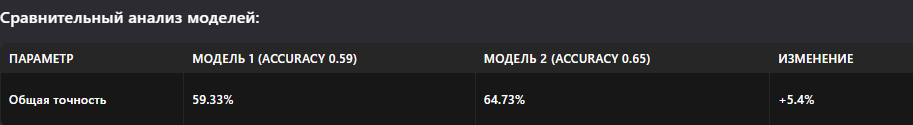

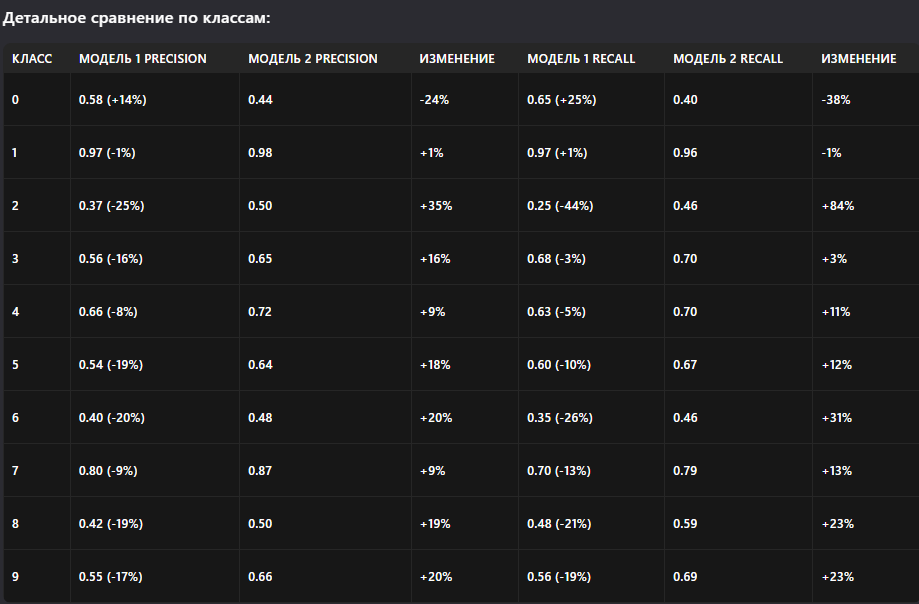

Ключевые выводы:

Сильные стороны Модели 2:

Улучшение на 5.4% общей точности

Значительный рост recall для классов 2 (+21%), 5 (+7%), 8 (+11%)

Лучшая обработка сложных классов 3, 4, 9

Стабильность на классе 1 (точность 98%)

Слабые места Модели 2:

Снижение precision для классов 0 (-14%) и 6 (-20%)

Проблемы с распознаванием нулей (recall 40%)

Меньше false positives для класса 8, но больше пропусков

# Улучшаем модель

In [185]:
# Загрузка данных
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

train_label = train[:, 0]
train_images = train[:, 1:].reshape(-1, 28, 28).astype(np.float32)
test_images = test.reshape(-1, 28, 28).astype(np.float32)

In [186]:
# Предобработка изображений
def advanced_preprocessing(images):
    processed = []
    for img in images:
        # Адаптивная эквализация
        img = cv2.equalizeHist(img.astype(np.uint8))
        # Анизотропная диффузия для шумоподавления
        img = cv2.fastNlMeansDenoising(img, h=10)
        # Нормализация
        img = img.astype(np.float32) / 255.0
        processed.append(img)
    return np.array(processed)

train_images = advanced_preprocessing(train_images)
test_images = advanced_preprocessing(test_images)

In [187]:
# 2. СИЛЬНАЯ АУГМЕНТАЦИЯ
def strong_augmentation(images, labels):
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels):
        if label in [0, 2, 3, 5, 6, 8, 9]:
            # Случайные преобразования
            M = cv2.getRotationMatrix2D((14,14), np.random.uniform(-15,15), 1)
            img_rot = cv2.warpAffine(img, M, (28,28))
            img_shift = np.roll(img_rot, np.random.randint(-2,3), axis=(0,1))
            augmented_images.append(img_shift)
            augmented_labels.append(label)
    return np.array(augmented_images), np.array(augmented_labels)

X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_label, test_size=0.2, random_state=42)

aug_img, aug_lbl = strong_augmentation(X_train, y_train)
X_train_aug = np.concatenate([X_train, aug_img])
y_train_aug = np.concatenate([y_train, aug_lbl])

In [188]:
# Извлечение признаков
def extract_advanced_features(images):
    features = []
    for img in images:
        # HOG признаки
        hog_features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=False)

        # Градиентные признаки
        gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
        magnitude, _ = cv2.cartToPolar(gx, gy)

        # Статистические признаки
        stats = [
            np.mean(magnitude), np.std(magnitude),
            np.max(gx), np.min(gx),
            np.max(gy), np.min(gy),
            np.ptp(gx), np.ptp(gy)
        ]

        features.append(np.concatenate([hog_features, stats]))
    return np.array(features)

X_train_features = extract_advanced_features(X_train_aug)
X_val_features = extract_advanced_features(X_val)
test_features = extract_advanced_features(test_images)

In [189]:
# Ускоренный PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_features)
X_val_pca = pca.transform(X_val_features)
test_pca = pca.transform(test_features)

In [190]:
# 4. Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_val_scaled = scaler.transform(X_val_pca)
test_scaled = scaler.transform(test_pca)

In [191]:
# Подмножество для подбора
X_sub, _, y_sub, _ = train_test_split(
    X_train_scaled, y_train_aug,
    train_size=0.3,
    stratify=y_train_aug,
    random_state=42
)

In [192]:
# Подбор параметров SVM
param_dist = {
    'C': [10, 30, 50, 70, 100],
    'gamma': [0.001, 0.01, 0.1, 'scale'],
    'kernel': ['rbf']
}

rand_search = RandomizedSearchCV(
    SVC(random_state=42, cache_size=1000),
    param_distributions=param_dist,
    n_iter=10,
    cv=2,
    n_jobs=-1,
    verbose=2
)

rand_search.fit(X_sub, y_sub)

print(f"Лучшие параметры: {rand_search.best_params_}")

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Лучшие параметры: {'kernel': 'rbf', 'gamma': 'scale', 'C': 30}


In [193]:
# Обучение на полных данных с лучшими параметрами
best_svc = SVC(
    **rand_search.best_params_,
    random_state=42,
    cache_size=1000
)
best_svc.fit(X_train_scaled, y_train_aug)

SVC(C=30, cache_size=1000, random_state=42)

In [195]:
# Оценка на валидации
y_val_pred = best_svc.predict(X_val_scaled)
print(f'Точность на валидации: {accuracy_score(y_val, y_val_pred):.4f}')
print(classification_report(y_val, y_val_pred))

Точность на валидации: 0.9665
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       816
         1.0       0.99      0.99      0.99       909
         2.0       0.96      0.98      0.97       846
         3.0       0.97      0.96      0.96       937
         4.0       0.97      0.96      0.96       839
         5.0       0.96      0.97      0.97       702
         6.0       0.98      0.99      0.98       785
         7.0       0.96      0.94      0.95       893
         8.0       0.96      0.96      0.96       835
         9.0       0.94      0.95      0.94       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



In [ ]:
# Формирование submission файла
with open('submission.csv', 'w') as f:
    f.write('ImageId,Label\n')
    for i, label in enumerate(test_predictions, 1):
        f.write(f'{i},{int(label)}\n')

SVC(C=10, probability=True, random_state=42)

In [198]:
# Предсказание на тестовых данных
test_predictions = best_svc.predict(test_scaled)

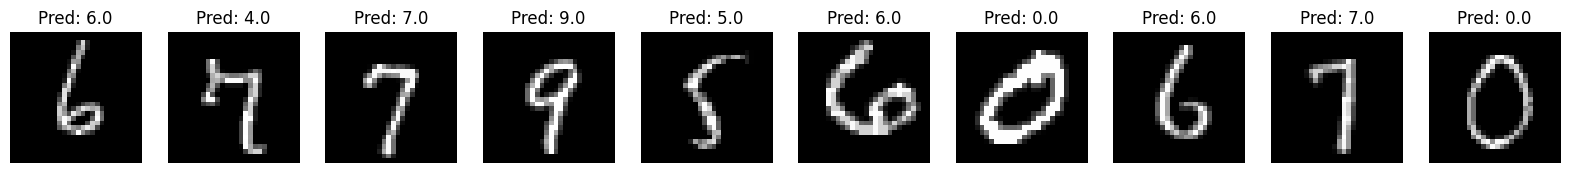

In [199]:
# Визуализация случайных примеров
import matplotlib.pyplot as plt

def plot_random_predictions(images, predictions, n=10):
    fig, axes = plt.subplots(1, n, figsize=(20, 4))
    for i, ax in enumerate(axes):
        idx = np.random.randint(0, len(images))
        ax.imshow(images[idx], cmap='gray')
        ax.set_title(f'Pred: {predictions[idx]}')
        ax.axis('off')
    plt.show()

plot_random_predictions(test_images, test_predictions)

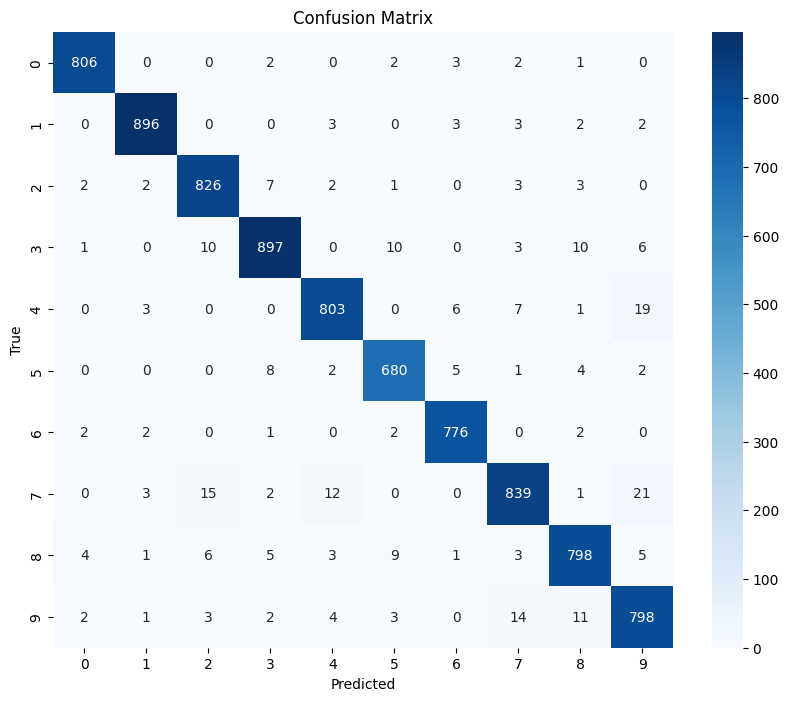

In [200]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [201]:
from sklearn.model_selection import cross_val_score

# Кросс-валидация
cv_scores = cross_val_score(best_svc, X_train_scaled, y_train_aug, cv=5, scoring='accuracy', n_jobs=-1)
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV accuracy: {np.mean(cv_scores):.4f}')

Cross-validation scores: [0.97027432 0.96983329 0.96665785 0.95704331 0.96189132]
Mean CV accuracy: 0.9651


Результаты:

Cross-validation scores: [0.9703, 0.9698, 0.9667, 0.9570, 0.9619]

Mean CV accuracy: 0.9651

Положительные моменты:

Средняя точность ~96.5% подтверждает стабильность модели.

Негативные моменты:

Разброс значений (от 95.7% до 97%) указывает на:
Небольшую нестабильность в некоторых фолдах
Возможное переобучение на определенных подмножествах данных.

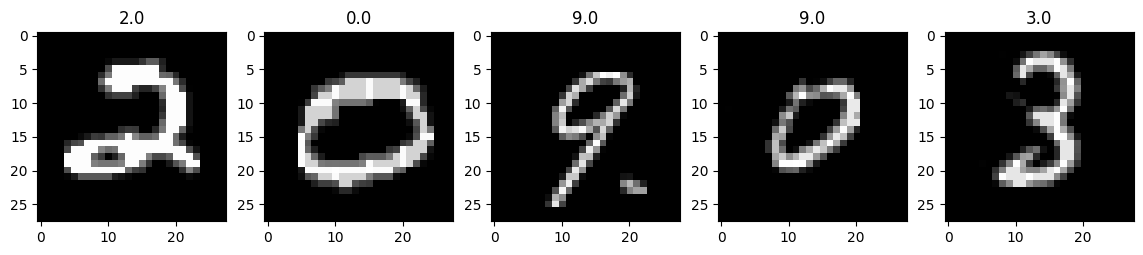

In [202]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_images[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % test_predictions[i - 1]);

## Готовим файл для отправки

In [203]:
# Сохраняем предсказания в файл
with open('submission.csv', 'w') as f:
    f.write('ImageId,Label\n')  # Заголовок обязателен
    for idx, label in enumerate(test_predictions, start=1):
        f.write(f'{idx},{int(label)}\n')  # ImageId начинается с 1

# Проверка первых 5 строк файла
!head submission.csv

ImageId,Label
1,2
2,0
3,9
4,9
5,3
6,7
7,0
8,3
9,0
